In [1]:
import numpy as np
import pandas as pd
import scipy as scp 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.datasets

### Create Data for clustering

Simulate data from 5 different Gaussian distributions with different mean and covariance. Each of these distributions will be learnt and clustered separately using K-Means and EM-GMM

In [2]:
# Number of Dims (D) for X = 2

np.random.seed(6962)

trg_1 = 0
trg_2 = 1
trg_3 = 2
trg_4 = 3
trg_5 = 4

sample_size_1 = 5000
sample_size_2 = 2000
sample_size_3 = 3000
sample_size_4 = 4000
sample_size_5 = 1000

In [3]:
# Samples with D = 5

# samples_cluster_1 = np.random.multivariate_normal(mean=[1, 3, 2, 7, 1], cov = sklearn.datasets.make_spd_matrix(5, random_state=None), size=sample_size_1)
# samples_cluster_1 = np.hstack([samples_cluster_1, np.array([trg_1] * sample_size_1).reshape(sample_size_1, 1)])

# samples_cluster_2 = np.random.multivariate_normal(mean=[2, 2, -1, 6, 5], cov = sklearn.datasets.make_spd_matrix(5, random_state=None), size=sample_size_2)
# samples_cluster_2 = np.hstack([samples_cluster_2, np.array([trg_2] * sample_size_2).reshape(sample_size_2, 1)])

# samples_cluster_3 = np.random.multivariate_normal(mean=[3, 3, -2, 4, 1], cov = sklearn.datasets.make_spd_matrix(5, random_state=None), size=sample_size_3)
# samples_cluster_3 = np.hstack([samples_cluster_3, np.array([trg_3] * sample_size_3).reshape(sample_size_3, 1)])

# samples_cluster_4 = np.random.multivariate_normal(mean=[4, -6, -2, 1, 3], cov = sklearn.datasets.make_spd_matrix(5, random_state=None), size=sample_size_4)
# samples_cluster_4 = np.hstack([samples_cluster_4, np.array([trg_4] * sample_size_4).reshape(sample_size_4, 1)])

# samples_cluster_5 = np.random.multivariate_normal(mean=[-2, 5, -3, 8, 1], cov = sklearn.datasets.make_spd_matrix(5, random_state=None), size=sample_size_5)
# samples_cluster_5 = np.hstack([samples_cluster_5, np.array([trg_5] * sample_size_5).reshape(sample_size_5, 1)])

In [4]:
# Samples with D = 2 for easier visualization
samples_cluster_1 = np.random.multivariate_normal(mean=[1, 3], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_1)
samples_cluster_1 = np.hstack([samples_cluster_1, np.array([trg_1] * sample_size_1).reshape(sample_size_1, 1)])

c1 = np.repeat(0, sample_size_1)

c2 = np.repeat(1, sample_size_2)
c3 = np.repeat(2, sample_size_3)
c4 = np.repeat(3, sample_size_4)
c5 = np.repeat(4, sample_size_5)

samples_cluster_2 = np.random.multivariate_normal(mean=[2, -1], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_2)
samples_cluster_2 = np.hstack([samples_cluster_2, np.array([trg_2] * sample_size_2).reshape(sample_size_2, 1)])

samples_cluster_3 = np.random.multivariate_normal(mean=[-3, -2], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_3)
samples_cluster_3 = np.hstack([samples_cluster_3, np.array([trg_3] * sample_size_3).reshape(sample_size_3, 1)])

samples_cluster_4 = np.random.multivariate_normal(mean=[4, -6], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_4)
samples_cluster_4 = np.hstack([samples_cluster_4, np.array([trg_4] * sample_size_4).reshape(sample_size_4, 1)])

samples_cluster_5 = np.random.multivariate_normal(mean=[-2, 5], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_5)
samples_cluster_5 = np.hstack([samples_cluster_5, np.array([trg_5] * sample_size_5).reshape(sample_size_5, 1)])

Combine all the samples from the 5 distributions and shuffle. This will ensure input data sequence is random. 

In [5]:
X = np.vstack([samples_cluster_1, samples_cluster_2, samples_cluster_3, samples_cluster_4, samples_cluster_5])
C = np.concatenate([c1, c2, c3, c4, c5], axis=0)
random_state = np.random.get_state()

np.random.shuffle(X)
np.random.set_state(random_state)
np.random.shuffle(C)
X = np.delete(X, np.s_[-1:], axis=1)
np.savetxt("X.csv", X, delimiter=",")

In [18]:
print(X.shape)

(15000, 2)


### Plot

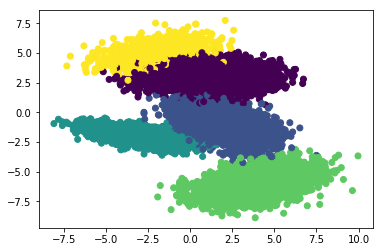

In [6]:
plt.scatter(X[:,0], X[:,1], c=C)

There are some clear visual patterns of the 5 clusters.

We will now learn these clusters using the following 2 models:
 * K-Means (Hard Clustering)
 * Gaussian Mixure Model (using EM method) 

## K-Means

Define KMeans two step process:
 * Assign each input sample to the nearest centroid
 * Recompute each centroid value based on new assigment of input samples

In [11]:
def KMeans_one_step(X, mu):
    C = []
    # Assignment step - assign each x to the nearest centroid. This means find ci for each xi.
    for x in X:
        l2 = []
        for mu_k in mu:
            l2.append(np.linalg.norm(x - mu_k)**2)
        C.append(np.argmin(l2))
    K, n_K = np.unique(C, return_counts=True)
    
    plt.scatter(X[:,0], X[:,1], c=np.array(C))
    plt.show()
    
    # Update step - Recalculate centroid for each cluster based on xi assignment toe cluster

    _mu = []
    for k, n_k in zip(K, n_K):
        mu_k = np.dot((C == k), X)/n_k
        _mu.append(mu_k)
    return _mu

## Coordinate Descent
Run coodinate descent algorithm for 10 iterations to optimize cluster centroids and assignments of input samples

Iteration  1


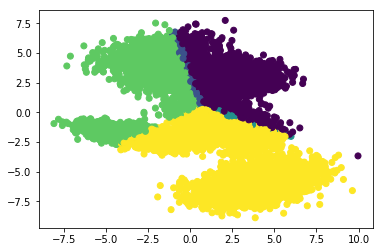

Iteration  2


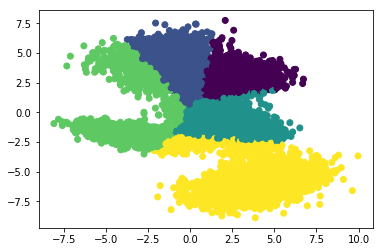

Iteration  3


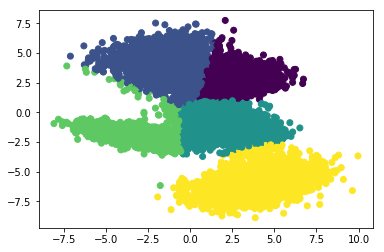

Iteration  4


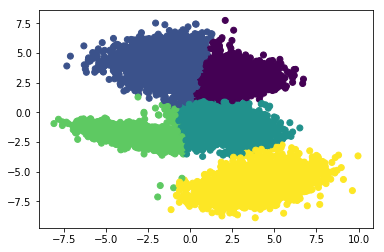

Iteration  5


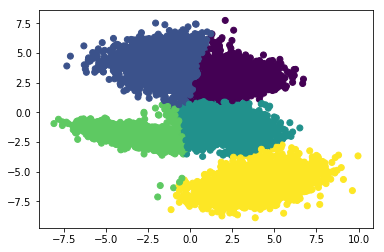

Iteration  6


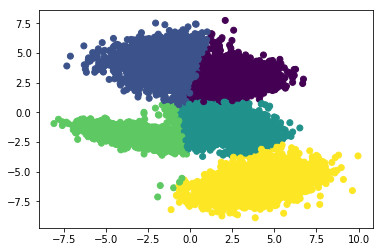

Iteration  7


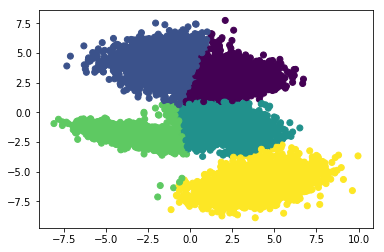

Iteration  8


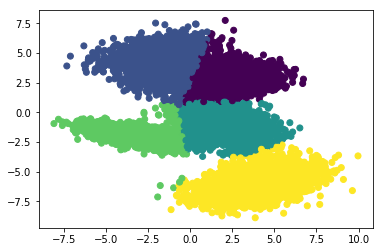

Iteration  9


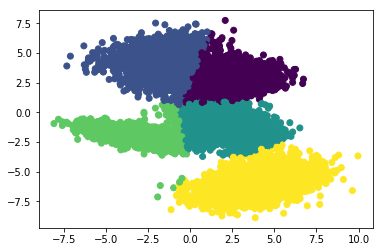

Iteration  10


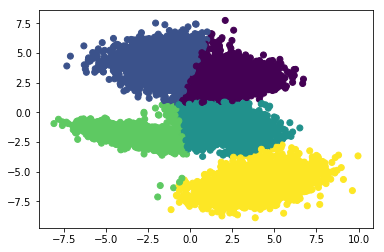

In [12]:
# Initialize the centroids randomly
mu = np.random.rand(5, X.shape[1])

# Calculate centroid for each cluster for 10 iterations
for ctr in range(10):
    print("Iteration ", ctr+1)
    mu = KMEAN_one_step(X, mu)

## EM-GMM

Implement the soft clustering algorithm using EM-GMM 

In [ ]:
# TODO